# Diffusion-based Speech Enhancement Demo

This demo presents advanced techniques in speech enhancement using deep generative models.

We compare SGMSE+ [1] with Schrödinger bridge approaches [2, 3].

The presented methods focus on generating high-quality super-wideband speech at a sampling rate of 48 kHz.

Participants will record speech using a single microphone in a noisy environment, such as a conference venue.

These recordings will then be enhanced and played back through headphones.

We aim to demonstrate the model's effectiveness in improving speech quality and intelligibility.

```text
[1] J. Richter, S. Welker, J.-M. Lemercier, B. Lay, and T. Gerkmann,
    “Speech enhancement and dereverberation with diffusion-based generative models,”
    IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 31, pp. 2351–2364, 2023.

[2] A. Jukić, R. Korostik, J. Balam, and B. Ginsburg,
    “Schrödinger bridge for generative speech enhancement,”
    Proceedings of Interspeech, pp. 1175-1179, 2024.    

[3] J. Richter, D. de Oliveira, T. Gerkmann,
    “Investigating Training Objectives for Generative Speech Enhancement,”
    submitted to IEEE International Conference on Acoustics, Speech, and Signal Processing.
```

In [1]:
!git clone https://github.com/maxbsoft/gen-se-demo.git .

Cloning into '.'...
remote: Enumerating objects: 758, done.
remote: Counting objects: 100% (758/758), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 758 (delta 462), reused 748 (delta 454), pack-reused 0 (from 0)
Receiving objects: 100% (758/758), 16.69 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (462/462), done.


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 45.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.4 MB/s eta 0:00:00
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

## Load packages

In [1]:
import os
from sgmse.util.other import set_torch_cuda_arch_list

# GPU set up
# os.environ["CUDA_VISIBLE_DEVICES"]="4"
set_torch_cuda_arch_list()

import torch
import numpy as np
import soundfile as sf
# import sounddevice as sd
import ipywidgets as widgets

from matplotlib import pyplot as plt
from sgmse.util.other import pad_spec, get_inference_objects
from sgmse.util.visualization import plot_spec, plot_spec_dual, plot_audio
from sgmse.model import ScoreModel
from IPython.display import display, Audio

import warnings
# Suppress specific warning messages (adjust the regex pattern to match the warning you're suppressing)
warnings.filterwarnings("ignore", message=r"You are using `torch.load` with `weights_only=False`.*")

Set TORCH_CUDA_ARCH_LIST to: 8.9


## Download the pre-trained models

In [2]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sgmse.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb-pesq.ckpt

--2025-12-12 15:03:58--  https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sgmse.ckpt
Resolving www2.informatik.uni-hamburg.de (www2.informatik.uni-hamburg.de)... 134.100.9.79
Connecting to www2.informatik.uni-hamburg.de (www2.informatik.uni-hamburg.de)|134.100.9.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1295841456 (1.2G)
Saving to: ‘checkpoints/sgmse.ckpt’

sgmse.ckpt          100%[===================>]   1.21G  11.9MB/s    in 1m 58s  

2025-12-12 15:05:57 (10.5 MB/s) - ‘checkpoints/sgmse.ckpt’ saved [1295841456/1295841456]

--2025-12-12 15:05:57--  https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb.ckpt
Resolving www2.informatik.uni-hamburg.de (www2.informatik.uni-hamburg.de)... 134.100.9.79
Connecting to www2.informatik.uni-hamburg.de (www2.informatik.uni-hamburg.de)|134.100.9.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1297096659 (1.2

## Load models

In [3]:
device_slider = widgets.Dropdown(options=['CPU', 'GPU'], value='GPU', description='Device:', disabled=False)
display(device_slider)

Dropdown(description='Device:', index=1, options=('CPU', 'GPU'), value='GPU')

In [5]:
import torch
import sgmse.data_module

# allowlist классов, которые есть в checkpoint (PyTorch 2.6+ security change)
torch.serialization.add_safe_globals([
    sgmse.data_module.SpecsDataModule,
])

In [6]:
device = torch.device("cuda" if device_slider.value == 'GPU' else "cpu")

sb_checkpoint = 'checkpoints/sb.ckpt'
sb_pesq_checkpoint = 'checkpoints/sb-pesq.ckpt'
sgmse_checkpoint = 'checkpoints/sgmse.ckpt'

sb_model = ScoreModel.load_from_checkpoint(sb_checkpoint, map_location=torch.device(device))
sb_pesq_model = ScoreModel.load_from_checkpoint(sb_pesq_checkpoint, map_location=torch.device(device))
sgmse_model = ScoreModel.load_from_checkpoint(sgmse_checkpoint, map_location=torch.device(device))

## Select or record audio

In [25]:
input_slider = widgets.Dropdown(options=['Record', 'examples/0rvmjMpZEmE_Emma__T__24-33.wav'], value='Record', description='Input:', disabled=False)
display(input_slider)

Dropdown(description='Input:', options=('Record', 'examples/0rvmjMpZEmE_Emma__T__24-33.wav'), value='Record')

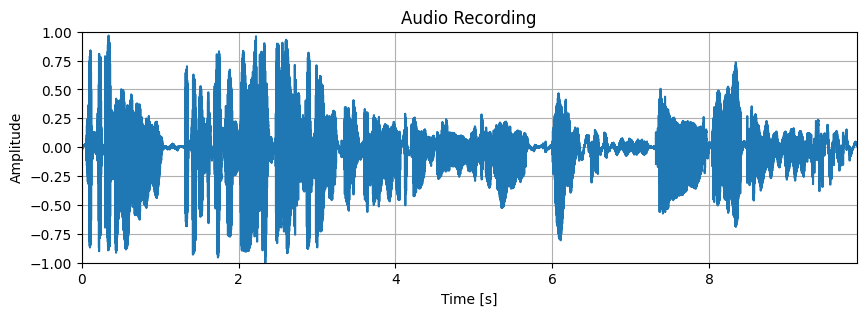

In [26]:
if input_slider.value == 'Record':
    duration = 10
    sr = 48000
    audio_data = sd.rec(int(duration*sr), samplerate=sr, channels=1)[:,0]
    sd.wait()
else:
    file_path = input_slider.value
    audio_data, sr = sf.read(file_path)

audio =  audio_data / np.max(np.abs(audio_data))

plot_audio(audio, sr)
display(Audio(audio, rate=sr, normalize=True))

## Inference

In [27]:
model_slider = widgets.Dropdown(options=['SGMSE+', 'SB', 'SB-PESQ', ], value='SGMSE+', description='Model:', disabled=False)
sampler_type_slider = widgets.Dropdown(options=['ODE', 'SDE'], value='SDE', description='Sampler:', disabled=False)
N_slider = widgets.SelectionSlider(options=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], value=30, description='N:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)

display(model_slider)
display(sampler_type_slider)
display(N_slider)

Dropdown(description='Model:', options=('SGMSE+', 'SB', 'SB-PESQ'), value='SGMSE+')

Dropdown(description='Sampler:', index=1, options=('ODE', 'SDE'), value='SDE')

SelectionSlider(continuous_update=False, description='N:', index=6, options=(1, 5, 10, 15, 20, 25, 30, 35, 40,…

SGMSE+ SDE 35


100%|██████████| 35/35 [01:02<00:00,  1.78s/it]


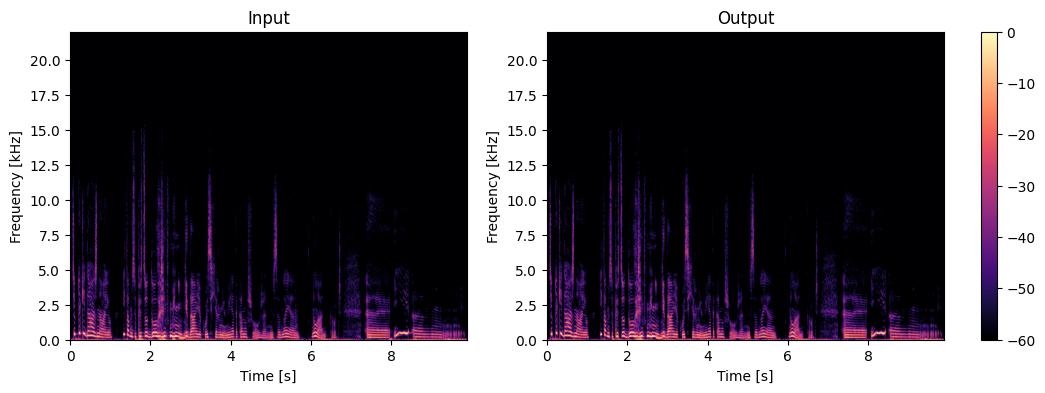

model_slider:Dropdown(description='Model:', options=('SGMSE+', 'SB', 'SB-PESQ'), value='SGMSE+')
sampler_type_slider:Dropdown(description='Sampler:', index=1, options=('ODE', 'SDE'), value='SDE')
N_slider:SelectionSlider(continuous_update=False, description='N:', index=7, options=(1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50), value=35)


In [31]:
# Get inference objects
model, sampler_type, N = get_inference_objects(model_slider, sampler_type_slider, N_slider, sgmse_model, sb_model, sb_pesq_model)
print(model_slider.value, sampler_type_slider.value, N_slider.value)

# Transfer audio to GPU
audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).to(device)

# Enhance audio
x_hat = model.enhance(audio_tensor, sampler_type=sampler_type, N=N)

# Play enhanced audio
display(Audio(audio, rate=sr, normalize=True))
display(Audio(x_hat, rate=sr, normalize=True))
plot_spec_dual(audio, sr, x_hat, sr, target_sr=sr)

print(f"model_slider:{model_slider}")
print(f"sampler_type_slider:{sampler_type_slider}")
print(f"N_slider:{N_slider}")